In [1]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import flwr as fl
from flwr.common import Metrics
import random
import torch.nn as nn
from typing import Union, Optional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from tqdm import tqdm, trange
import pickle
import seaborn as sns
DEVICE = torch.device("cpu")

/opt/homebrew/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <0B637046-A38B-3A5C-80C6-E847C27DCCD5> /opt/homebrew/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <3AE92490-D363-3FD7-8532-CB6F5F795BC8> /opt/homebrew/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-09 10:39:56,311	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
with open('./data/classification_data.pkl', 'rb') as f:
            data = pickle.load(f)

In [3]:
l2idx = {l:i for i, l in enumerate(set([y for _, y in data['Consumer1']]))}

In [4]:
class ClassificationData(Dataset):
    def __init__(self, data):
        self.x = [x for x, _ in data]
        self.Y = [y for _, y in data]
        self.l2idx = {l:i for i, l in enumerate(sorted(list(set(self.Y))))}
        self.idx2l = {i:l for l, i in l2idx.items()}
        
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, i):
        return torch.tensor(self.x[i], dtype=torch.float), torch.tensor(self.l2idx[self.Y[i]], dtype=torch.long)

In [5]:
class MultiToOneRNN(nn.Module):
    def __init__(self, hidden_size, num_layers=2, output_size=10, LSTM=False, bidirectional=False):
        super(MultiToOneRNN, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM = LSTM
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.directions = 1 if not self.bidirectional else 2
        if LSTM:
            self.rnn = nn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        else:
            self.rnn = nn.RNN(input_size=1, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
            
        self.fc1 = nn.Linear(self.hidden_size*self.directions, output_size)
        #self.fc2 = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, inputs, hidden_state, cell=None):
        if self.LSTM:
            output, (hidden_states, cell) = self.rnn(inputs, (hidden_state, cell))
        else:
            output, hidden_states = self.rnn(inputs, hidden_state)
        output = self.fc1(output)
        return output, hidden_states, cell

In [6]:
epochs = 5
def train(net, train_loader, lr):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    num_layers = net.num_layers
    batch_size = train_loader.batch_size
    val_losses = []
    directions = 1 if not net.bidirectional else 2
    for epoch in range(epochs):
        net.train()
        total_loss = 0.0
        golds = []
        preds = []
        for x, Y in tqdm(train_loader):
            Y = Y.to(DEVICE)
            x = x.to(DEVICE).view(batch_size, -1, 1)
            hidden = torch.zeros((num_layers*directions, batch_size, net.hidden_size)).to(DEVICE)
            cell = torch.zeros((num_layers*directions, batch_size, net.hidden_size)).to(DEVICE)
            outs, hidden, cell = net(x, hidden, cell)
            loss = criterion(outs[:, -1], Y)    
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = torch.argmax((F.softmax(outs[:, -1], dim=-1)), dim=-1)
            preds += pred.tolist()
            golds += Y.tolist()
            optimizer.zero_grad()
        val_losses.append(total_loss / len(train_loader))
        acc = np.mean((np.array(golds) == np.array(preds)))
        print(f' Training loss for epoch {epoch}: {total_loss / len(train_loader)}, accuracy: {acc}')
       
    return val_losses

# Non-Federated learning (sanity check on train set )

In [ ]:
data_plus = []
for consumer in data:
    data_plus += data[consumer]

In [ ]:
train_data = ClassificationData(data_plus)

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)

In [ ]:
model = MultiToOneRNN(64, LSTM=False, bidirectional=True).to(DEVICE)

In [ ]:
losses = train(model, train_loader)

In [ ]:
plt.plot(losses)

# Federated learning

In [47]:
batch_size = 16
hidden_size = 256
learning_rate = 3e-4
USE_LSTM = True
ROUNDS = 25

In [48]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [49]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, dataset):
        self.net = net
        self.dataset = dataset
        self.losses = []

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        loss = train(self.net, self.dataset, lr=learning_rate)
        self.losses = loss
        return get_parameters(self.net), len(self.dataset), {'loss': np.mean(loss)}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        return 0.0, 1, {}


def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Load model
    cid = int(cid) + 1
    net = MultiToOneRNN(hidden_size=hidden_size, LSTM=USE_LSTM).to(DEVICE)
    d = ClassificationData(data[f'Consumer{cid}'])
    train_loader = DataLoader(d, batch_size=batch_size, shuffle=True, drop_last=True)

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, train_loader)


class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes], BaseException]],
    ):
        """Aggregate model weights using weighted average and store checkpoint"""
        net = MultiToOneRNN(hidden_size=hidden_size, LSTM=USE_LSTM).to(DEVICE)

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...", flush=True)

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            net.load_state_dict(state_dict, strict=True)

            # Save the model
            model_name = 'lstm' if USE_LSTM else 'rnn'
            torch.save(net.state_dict(), f"classification_model_{model_name}_round_{server_round}.pth")
            print(f"Saved round {server_round} aggregated_parameters!", flush=True)


        return aggregated_parameters, aggregated_metrics

def agg(metrics):
    losses = np.mean([m[-1]["loss"] for m in metrics])
    return {'losses': losses}



In [50]:
# Create FedAvg strategy
strategy = SaveModelStrategy(
    fraction_fit=0.25,  # Sample 100% of available clients for training
    fraction_evaluate=0.0,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=0,  # Never sample less than 5 clients for evaluation
    min_available_clients=40,  # Wait until all 10 clients are available
    fit_metrics_aggregation_fn= agg
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
res = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=40,
    config=fl.server.ServerConfig(num_rounds=ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-11-09 11:37:57,014 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
2023-11-09 11:38:00,469	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2023-11-09 11:38:00,987 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 8231487079.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 8231487079.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-11-09 11:38:00,988 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-11-09 11:38:00,988 | app.py:224 | Flower VCE: Resources for each Virtual Client

(DefaultActor pid=92320)  Training loss for epoch 0: 2.2949662501351877, accuracy: 0.11321271929824561


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 0: 2.2526672472033584, accuracy: 0.12746710526315788 [repeated 2x across cluster]


 40%|███▉      | 91/228 [00:10<00:16,  8.31it/s] [repeated 6x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 0: 2.2572054732264135, accuracy: 0.13349780701754385 [repeated 5x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 2.1788111219280646, accuracy: 0.16282894736842105
(DefaultActor pid=92319)  Training loss for epoch 1: 2.3038426888616463, accuracy: 0.09292763157894737


 99%|█████████▉| 226/228 [00:27<00:00,  8.12it/s] [repeated 63x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 1: 2.3094406588035716, accuracy: 0.10279605263157894 [repeated 3x across cluster]


 95%|█████████▌| 217/228 [00:27<00:01,  8.12it/s] [repeated 36x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 2.0240500062181237, accuracy: 0.23739035087719298 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 2.0432723368469037, accuracy: 0.21929824561403508
(DefaultActor pid=92319)  Training loss for epoch 2: 2.3063814357707373, accuracy: 0.10005482456140351


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 2: 1.9991375490238792, accuracy: 0.21765350877192982
(DefaultActor pid=92316)  Training loss for epoch 2: 2.172351416788603, accuracy: 0.18887061403508773


100%|██████████| 228/228 [00:28<00:00,  8.01it/s] [repeated 30x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 2: 1.813732871883794, accuracy: 0.34155701754385964 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 2.29797652625201, accuracy: 0.09978070175438597
(DefaultActor pid=92320)  Training loss for epoch 3: 2.157997477472874, accuracy: 0.18146929824561403


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 3: 2.255103406153227, accuracy: 0.13815789473684212
(DefaultActor pid=92316)  Training loss for epoch 3: 2.05756469515332, accuracy: 0.21984649122807018


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 3: 2.2445363208912967, accuracy: 0.14501096491228072 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92313)  Training loss for epoch 3: 2.212585195637586, accuracy: 0.16611842105263158


 63%|██████▎   | 144/228 [00:17<00:09,  8.41it/s] [repeated 6x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 4: 1.7933921238832307, accuracy: 0.36019736842105265


 97%|█████████▋| 222/228 [00:26<00:00,  8.67it/s] [repeated 17x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 4: 2.310499683806771, accuracy: 0.10087719298245613 [repeated 2x across cluster]


 93%|█████████▎| 212/228 [00:25<00:01, 11.41it/s] [repeated 39x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 4: 2.3088259289139197, accuracy: 0.08552631578947369 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 2.28676185168718, accuracy: 0.12335526315789473 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 2.1247217351930185, accuracy: 0.2069627192982456 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 2.30703460124501, accuracy: 0.09457236842105263 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 2.3050365479368913, accuracy: 0.10005482456140351 [repeated 2x across cluster]


 95%|█████████▍| 216/228 [00:12<00:00, 17.82it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 2.3058155565931084, accuracy: 0.08717105263157894 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 11:41:34,459 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures


Saving round 1 aggregated_parameters...
Saved round 1 aggregated_parameters!


INFO flwr 2023-11-09 11:41:34,511 | server.py:171 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
DEBUG flwr 2023-11-09 11:41:34,512 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 1.951993600841154, accuracy: 0.27247807017543857 [repeated 2x across cluster]


 25%|██▍       | 56/228 [00:06<00:18,  9.12it/s] [repeated 281x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 0: 1.8682593190879153, accuracy: 0.3144188596491228 [repeated 3x across cluster]


 44%|████▍     | 100/228 [00:11<00:14,  9.07it/s] [repeated 3x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 0: 2.146461632168084, accuracy: 0.19407894736842105 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 1.6045426104152412, accuracy: 0.40268640350877194


  1%|          | 2/228 [00:00<00:25,  8.81it/s] [repeated 2x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 1: 1.9030134960224754, accuracy: 0.26535087719298245


 75%|███████▌  | 172/228 [00:23<00:07,  7.89it/s] [repeated 11x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 1.9601717042295557, accuracy: 0.2837171052631579


 90%|█████████ | 206/228 [06:25<00:02,  8.13it/s] [repeated 229x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 1: 1.671312934996789, accuracy: 0.39528508771929827


  7%|▋         | 17/228 [00:02<00:26,  7.86it/s] [repeated 219x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 1: 2.0164551034308316, accuracy: 0.22998903508771928 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 1.784211669836128, accuracy: 0.31716008771929827


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.8575199230721122, accuracy: 0.26398026315789475


 67%|██████▋   | 152/228 [08:34<00:08,  8.82it/s] [repeated 17x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 2: 2.308592469022985, accuracy: 0.09018640350877193


 88%|████████▊ | 200/228 [08:41<00:03,  8.29it/s] [repeated 10x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 2: 1.4050138543049495, accuracy: 0.5257675438596491


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.910575949309165, accuracy: 0.29577850877192985 [repeated 5x across cluster]


 97%|█████████▋| 222/228 [01:14<00:00,  7.70it/s]


(DefaultActor pid=92313)  Training loss for epoch 3: 2.3071666840921368, accuracy: 0.09868421052631579 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 3: 1.7004899440104502, accuracy: 0.3919956140350877 [repeated 5x across cluster]


100%|█████████▉| 227/228 [05:20<00:00,  5.28it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 1.6532193712498013, accuracy: 0.40734649122807015


 98%|█████████▊| 223/228 [05:20<00:00,  7.95it/s] [repeated 15x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 2.0089414166776756, accuracy: 0.23135964912280702


 93%|█████████▎| 211/228 [05:20<00:02,  7.48it/s]


(DefaultActor pid=92313)  Training loss for epoch 4: 2.3071808177128172, accuracy: 0.09676535087719298
(DefaultActor pid=92316)  Training loss for epoch 4: 2.307270615770106, accuracy: 0.0956688596491228


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 2.1280022807288588, accuracy: 0.21244517543859648 [repeated 5x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 2.3181032141049704, accuracy: 0.11513157894736842 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 2.1384065485837165, accuracy: 0.20285087719298245 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.8633345956342262, accuracy: 0.29577850877192985 [repeated 2x across cluster]


100%|██████████| 228/228 [00:14<00:00, 16.17it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 2.1131310823716616, accuracy: 0.21052631578947367 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 12:05:07,187 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


Saving round 2 aggregated_parameters...
Saved round 2 aggregated_parameters!


INFO flwr 2023-11-09 12:05:07,238 | server.py:171 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
DEBUG flwr 2023-11-09 12:05:07,238 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 1.8359068355016541, accuracy: 0.2768640350877193 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 0: 1.7523637225753383, accuracy: 0.33278508771929827 [repeated 2x across cluster]


 11%|█▏        | 26/228 [00:03<00:23,  8.60it/s] [repeated 238x across cluster]


(DefaultActor pid=92316) 


 11%|█▏        | 26/228 [00:02<00:22,  8.87it/s] [repeated 5x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 0: 1.6377048157809073, accuracy: 0.3900767543859649 [repeated 5x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92313) 
(DefaultActor pid=92319)  Training loss for epoch 1: 1.7252571611550815, accuracy: 0.3717105263157895
(DefaultActor pid=92320)  Training loss for epoch 1: 1.6179794083561814, accuracy: 0.39035087719298245


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 1: 2.0492386101630697, accuracy: 0.23519736842105263


 27%|██▋       | 62/228 [00:07<00:18,  8.83it/s] [repeated 284x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 1: 1.761532815924862, accuracy: 0.3182565789473684


 46%|████▋     | 106/228 [00:12<00:13,  8.74it/s] [repeated 252x across cluster]


(DefaultActor pid=92313) 
(DefaultActor pid=92313)  Training loss for epoch 1: 1.876532834872865, accuracy: 0.30838815789473684 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.8321681012187088, accuracy: 0.32648026315789475


 60%|█████▉    | 136/228 [00:17<00:16,  5.71it/s] [repeated 6x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 2: 1.9783275038526769, accuracy: 0.28234649122807015


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 2: 1.8241195976734161, accuracy: 0.3130482456140351


 91%|█████████ | 208/228 [00:24<00:02,  8.50it/s] [repeated 3x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 2: 1.5675591920551502, accuracy: 0.44709429824561403


 98%|█████████▊| 223/228 [00:28<00:00,  8.61it/s] [repeated 34x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 2: 1.5674410789159305, accuracy: 0.40652412280701755 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.6487521121376438, accuracy: 0.3692434210526316


100%|█████████▉| 227/228 [00:26<00:00,  8.50it/s] [repeated 35x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.6788932466716098, accuracy: 0.3656798245614035


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 3: 1.6765922752388738, accuracy: 0.37472587719298245


 92%|█████████▏| 209/228 [00:26<00:02,  8.10it/s] [repeated 26x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 1.6057148421542686, accuracy: 0.4331140350877193


 94%|█████████▍| 214/228 [00:27<00:01,  8.24it/s] [repeated 44x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 3: 1.1997003604968388, accuracy: 0.5819627192982456 [repeated 3x across cluster]


 93%|█████████▎| 211/228 [00:25<00:02,  8.30it/s] [repeated 14x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 1.8694074174814057, accuracy: 0.28152412280701755 [repeated 2x across cluster]


 92%|█████████▏| 209/228 [00:24<00:02,  8.64it/s] [repeated 19x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 4: 1.5979390447599846, accuracy: 0.42023026315789475 [repeated 2x across cluster]


 52%|█████▏    | 119/228 [00:15<00:11,  9.15it/s]


(DefaultActor pid=92317)  Training loss for epoch 4: 1.1850193159883482, accuracy: 0.6271929824561403 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 1.750106545393927, accuracy: 0.32648026315789475 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 1.7126592361090476, accuracy: 0.3495065789473684 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.5970360106020642, accuracy: 0.4081688596491228 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.6343134448193668, accuracy: 0.3972039473684211 [repeated 2x across cluster]
(DefaultActor pid=92320) 


 96%|█████████▌| 218/228 [00:13<00:00, 16.45it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 1.888310583537085, accuracy: 0.34018640350877194 [repeated 2x across cluster]


 91%|█████████ | 208/228 [00:12<00:01, 16.79it/s] [repeated 69x across cluster]
DEBUG flwr 2023-11-09 12:08:41,463 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


Saving round 3 aggregated_parameters...
Saved round 3 aggregated_parameters!


INFO flwr 2023-11-09 12:08:41,520 | server.py:171 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
DEBUG flwr 2023-11-09 12:08:41,521 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 1.5249018127980984, accuracy: 0.4133771929824561 [repeated 2x across cluster]


  9%|▉         | 21/228 [00:02<00:22,  9.12it/s] [repeated 3x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 0: 1.102442835245216, accuracy: 0.6143092105263158 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 0: 1.6319317587634974, accuracy: 0.3736293859649123 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 1.453691204911784, accuracy: 0.43777412280701755 [repeated 3x across cluster]


 71%|███████   | 161/228 [00:21<00:08,  7.82it/s] [repeated 301x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.7330395536203134, accuracy: 0.7538377192982456 [repeated 2x across cluster]


 49%|████▉     | 112/228 [00:12<00:12,  9.09it/s] [repeated 3x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 1: 1.1820321767999415, accuracy: 0.5441337719298246 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 1.2667533326567264, accuracy: 0.5054824561403509 [repeated 2x across cluster]


100%|██████████| 228/228 [00:27<00:00,  8.44it/s] [repeated 2x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 2: 0.6635079479269814, accuracy: 0.7675438596491229 [repeated 2x across cluster]


 98%|█████████▊| 224/228 [00:28<00:00,  8.38it/s] [repeated 33x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 2: 1.541280842402525, accuracy: 0.44243421052631576 [repeated 5x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.1219985895512397, accuracy: 0.5550986842105263
(DefaultActor pid=92319)  Training loss for epoch 3: 1.5587093960820584, accuracy: 0.42872807017543857


 93%|█████████▎| 212/228 [00:25<00:01,  8.85it/s] [repeated 4x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 1.6855727849822295, accuracy: 0.37198464912280704


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 3: 1.404630880606802, accuracy: 0.44024122807017546


 12%|█▏        | 27/228 [00:03<00:23,  8.60it/s] [repeated 287x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 3: 1.1138017731800414, accuracy: 0.6014254385964912 [repeated 4x across cluster]


100%|█████████▉| 227/228 [00:27<00:00,  8.80it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 1.0504765544544186, accuracy: 0.5773026315789473


 29%|██▊       | 65/228 [00:08<00:20,  8.15it/s] [repeated 260x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 1.3113210739796621, accuracy: 0.5052083333333334


100%|█████████▉| 227/228 [00:27<00:00,  8.42it/s]


(DefaultActor pid=92316)  Training loss for epoch 4: 1.7828317736847359, accuracy: 0.32319078947368424


 89%|████████▊ | 202/228 [00:24<00:02,  9.12it/s] [repeated 5x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 4: 1.3464576583682446, accuracy: 0.4668311403508772


 99%|█████████▊| 225/228 [00:27<00:00, 13.60it/s] [repeated 13x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 4: 1.1109418501718002, accuracy: 0.5970394736842105 [repeated 4x across cluster]


  9%|▉         | 20/228 [00:01<00:12, 16.60it/s] [repeated 71x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 0: 1.3598226384635557, accuracy: 0.5161732456140351 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 1.3609531490426314, accuracy: 0.47341008771929827


 15%|█▍        | 34/228 [00:02<00:11, 16.44it/s] [repeated 60x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 1: 1.1008807174992143, accuracy: 0.6091008771929824


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 1.3489654644539482, accuracy: 0.5010964912280702
(DefaultActor pid=92319)  Training loss for epoch 2: 1.0167897521403797, accuracy: 0.6115679824561403


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.3469058416391675, accuracy: 0.4849232456140351
(DefaultActor pid=92319)  Training loss for epoch 3: 1.117669999338033, accuracy: 0.5797697368421053


100%|██████████| 228/228 [00:14<00:00, 15.72it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 1.3004219066678433, accuracy: 0.5052083333333334


 82%|████████▏ | 186/228 [00:11<00:02, 17.16it/s] [repeated 65x across cluster]
DEBUG flwr 2023-11-09 12:12:21,013 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


Saving round 4 aggregated_parameters...
Saved round 4 aggregated_parameters!


INFO flwr 2023-11-09 12:12:21,075 | server.py:171 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
DEBUG flwr 2023-11-09 12:12:21,075 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 40)


(DefaultActor pid=92319)  Training loss for epoch 4: 1.0236428666271662, accuracy: 0.6071820175438597


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 1.3559783610858416, accuracy: 0.4649122807017544


 52%|█████▏    | 119/228 [00:14<00:11,  9.16it/s] [repeated 10x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 0: 1.364856389792342, accuracy: 0.46271929824561403


 80%|███████▉  | 182/228 [00:21<00:05,  9.03it/s] [repeated 279x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 0: 1.0524483325711467, accuracy: 0.615953947368421


100%|██████████| 228/228 [00:27<00:00,  8.16it/s] [repeated 23x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 0: 1.1338561373321634, accuracy: 0.5556469298245614


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 1.2228800518470897, accuracy: 0.5046600877192983 [repeated 5x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 1: 1.1288750984689646, accuracy: 0.581140350877193 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.2028051044857293, accuracy: 0.5134320175438597 [repeated 6x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 2: 0.9624086409284357, accuracy: 0.6165021929824561 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 2: 1.4464734732581859, accuracy: 0.4550438596491228 [repeated 4x across cluster]


 41%|████      | 93/228 [00:12<00:15,  8.55it/s] [repeated 269x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.1922636199415775, accuracy: 0.515625 [repeated 2x across cluster]


 29%|██▉       | 67/228 [00:08<00:19,  8.37it/s] [repeated 269x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 2.2351479786529875, accuracy: 0.13267543859649122 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 3: 1.0801744236235034, accuracy: 0.6334978070175439 [repeated 3x across cluster]


 41%|████      | 94/228 [00:12<00:17,  7.66it/s] [repeated 243x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 1.17974669133362, accuracy: 0.5194627192982456 [repeated 3x across cluster]


 15%|█▌        | 35/228 [00:03<00:20,  9.21it/s] [repeated 6x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 2.2540406323315803, accuracy: 0.1356907894736842 [repeated 2x across cluster]


 93%|█████████▎| 211/228 [00:27<00:01, 10.79it/s] [repeated 28x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 4: 1.3868492509712254, accuracy: 0.46710526315789475 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 1.2984573809724105, accuracy: 0.5356359649122807 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.9505070840057573, accuracy: 0.6491228070175439 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.9119867882446239, accuracy: 0.6620065789473685 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.8690685198495263, accuracy: 0.6814692982456141 [repeated 2x across cluster]


 96%|█████████▋| 220/228 [00:13<00:00, 17.03it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 1.1231568087088435, accuracy: 0.6069078947368421 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 12:15:57,706 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


Saving round 5 aggregated_parameters...
Saved round 5 aggregated_parameters!


INFO flwr 2023-11-09 12:15:57,769 | server.py:171 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
DEBUG flwr 2023-11-09 12:15:57,770 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.9801907553745989, accuracy: 0.6181469298245614 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 0: 1.4268547275610137, accuracy: 0.4479166666666667 [repeated 2x across cluster]


 44%|████▍     | 100/228 [00:11<00:15,  8.06it/s] [repeated 266x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 0: 1.1500133916474224, accuracy: 0.5526315789473685 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 1.0850448637155063, accuracy: 0.5995065789473685 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 1: 1.1817397075264078, accuracy: 0.5254934210526315 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92315)  Training loss for epoch 1: 1.6024147614575268, accuracy: 0.4144736842105263 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.9681668363903698, accuracy: 0.6258223684210527 [repeated 4x across cluster]


 92%|█████████▏| 209/228 [00:27<00:02,  8.22it/s] [repeated 21x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 2: 1.1674785731654418, accuracy: 0.5479714912280702 [repeated 2x across cluster]


 96%|█████████▌| 218/228 [00:27<00:01,  8.95it/s] [repeated 37x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 2: 0.8209264253576597, accuracy: 0.7143640350877193 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.9067544494020311, accuracy: 0.647203947368421 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 3: 1.128714647732283, accuracy: 0.5512609649122807 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 3: 1.2325065735923617, accuracy: 0.6154057017543859 [repeated 2x across cluster]


 18%|█▊        | 41/228 [00:05<00:22,  8.19it/s] [repeated 5x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.8618716517822784, accuracy: 0.6614583333333334 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 4: 1.135393666855076, accuracy: 0.5523574561403509 [repeated 2x across cluster]


 24%|██▍       | 55/228 [00:05<00:17, 10.01it/s] [repeated 3x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 4: 1.1353742531255673, accuracy: 0.6022478070175439
(DefaultActor pid=92314)  Training loss for epoch 4: 1.3017115266176693, accuracy: 0.5671600877192983


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 1.31769241497182, accuracy: 0.4786184210526316 [repeated 4x across cluster]


 83%|████████▎ | 190/228 [00:11<00:02, 17.20it/s] [repeated 72x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 1: 1.2562787890957112, accuracy: 0.4917763157894737 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 1.2386678169693863, accuracy: 0.4917763157894737 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.1858535223362738, accuracy: 0.5049342105263158 [repeated 2x across cluster]


100%|██████████| 228/228 [00:14<00:00, 16.17it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 1.1863029306395012, accuracy: 0.5123355263157895 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 12:19:37,557 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


Saving round 6 aggregated_parameters...
Saved round 6 aggregated_parameters!


INFO flwr 2023-11-09 12:19:37,613 | server.py:171 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
DEBUG flwr 2023-11-09 12:19:37,614 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.8744333478573122, accuracy: 0.6754385964912281 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 0: 0.7652497205295061, accuracy: 0.7025767543859649 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 0: 1.6339037745145328, accuracy: 0.34841008771929827 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.7470436025606958, accuracy: 0.7327302631578947 [repeated 2x across cluster]


 97%|█████████▋| 221/228 [00:26<00:00,  8.31it/s]


(DefaultActor pid=92316)  Training loss for epoch 1: 1.2287815166147131, accuracy: 0.5268640350877193 [repeated 2x across cluster]


 14%|█▍        | 33/228 [00:04<00:24,  7.98it/s] [repeated 239x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 1: 1.8872951627300496, accuracy: 0.3020833333333333 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.3292496064514445, accuracy: 0.4750548245614035 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92316)  Training loss for epoch 2: 1.0784930843010283, accuracy: 0.5726425438596491 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 2: 1.1564864277055389, accuracy: 0.575109649122807 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.2442566229586016, accuracy: 0.4909539473684211 [repeated 3x across cluster]


 66%|██████▌   | 151/228 [00:20<00:09,  7.78it/s] [repeated 275x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 1.1376598151890855, accuracy: 0.5575657894736842 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 3: 1.1628862437710428, accuracy: 0.571546052631579 [repeated 2x across cluster]


 20%|██        | 46/228 [00:05<00:21,  8.34it/s] [repeated 261x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 1.0267776527948547, accuracy: 0.6167763157894737 [repeated 4x across cluster]


 29%|██▉       | 67/228 [00:08<00:20,  7.96it/s] [repeated 226x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 1.1772253372167285, accuracy: 0.5405701754385965 [repeated 2x across cluster]


 81%|████████  | 185/228 [00:23<00:04, 10.11it/s] [repeated 216x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 4: 0.8275229293003417, accuracy: 0.7003837719298246 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 1.2477593947398036, accuracy: 0.5104166666666666 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 1.4499823490255757, accuracy: 0.43969298245614036 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.3475768861540578, accuracy: 0.46847587719298245 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.2330261173478343, accuracy: 0.5057565789473685 [repeated 2x across cluster]


 93%|█████████▎| 212/228 [00:12<00:00, 17.19it/s]
DEBUG flwr 2023-11-09 12:23:11,201 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


(DefaultActor pid=92320)  Training loss for epoch 4: 1.6237302649962275, accuracy: 0.44764254385964913 [repeated 2x across cluster]
Saving round 7 aggregated_parameters...
Saved round 7 aggregated_parameters!


INFO flwr 2023-11-09 12:23:11,256 | server.py:171 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
DEBUG flwr 2023-11-09 12:23:11,256 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 1.5410995635024287, accuracy: 0.4213267543859649 [repeated 2x across cluster]


 73%|███████▎  | 167/228 [00:22<00:07,  8.31it/s] [repeated 273x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 0: 1.118739226669596, accuracy: 0.5792214912280702 [repeated 2x across cluster]


 97%|█████████▋| 222/228 [00:28<00:00,  7.83it/s] [repeated 58x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 0: 1.2144536911918407, accuracy: 0.5027412280701754 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 1.2932123314393194, accuracy: 0.4758771929824561 [repeated 3x across cluster]


 96%|█████████▋| 220/228 [00:29<00:01,  7.93it/s] [repeated 13x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.9795520028524232, accuracy: 0.6175986842105263 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 1: 0.7171326968492123, accuracy: 0.7234100877192983 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.2404057658032368, accuracy: 0.4895833333333333 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92313)  Training loss for epoch 2: 0.9638537057397658, accuracy: 0.6165021929824561 [repeated 2x across cluster]


 19%|█▉        | 43/228 [00:05<00:22,  8.26it/s] [repeated 230x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 2: 1.517970757134128, accuracy: 0.4682017543859649 [repeated 5x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.3760716149158645, accuracy: 0.45614035087719296


  1%|          | 2/228 [00:00<00:25,  8.79it/s] [repeated 294x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.1478712153539323, accuracy: 0.5315241228070176


 93%|█████████▎| 212/228 [00:27<00:01,  9.15it/s]


(DefaultActor pid=92313)  Training loss for epoch 3: 0.9668839169960273, accuracy: 0.6156798245614035


 52%|█████▏    | 118/228 [00:14<00:12,  9.06it/s] [repeated 8x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 3: 1.0135362641068928, accuracy: 0.5995065789473685


 15%|█▍        | 34/228 [00:03<00:23,  8.37it/s] [repeated 254x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 3: 0.8193907434480232, accuracy: 0.6866776315789473 [repeated 4x across cluster]


 14%|█▎        | 31/228 [00:04<00:26,  7.30it/s] [repeated 260x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 2.2052586533521352, accuracy: 0.23163377192982457


 93%|█████████▎| 211/228 [00:25<00:01,  9.01it/s] [repeated 21x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 4: 1.1369854881052386, accuracy: 0.5296052631578947


 88%|████████▊ | 201/228 [00:23<00:05,  5.14it/s] [repeated 280x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 4: 1.387032013713268, accuracy: 0.5356359649122807
(DefaultActor pid=92315)  Training loss for epoch 4: 0.9970109483651948, accuracy: 0.5932017543859649


 86%|████████▌ | 195/228 [00:24<00:02, 11.20it/s] [repeated 116x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 4: 0.778365052321501, accuracy: 0.7003837719298246 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.7214874591220889, accuracy: 0.7302631578947368 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.9226702177210858, accuracy: 0.6387061403508771
(DefaultActor pid=92320)  Training loss for epoch 1: 0.7697992882315527, accuracy: 0.7154605263157895


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.9247562503605559, accuracy: 0.6389802631578947
(DefaultActor pid=92320)  Training loss for epoch 2: 1.1029193394801073, accuracy: 0.5509868421052632


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.8917183247313165, accuracy: 0.6463815789473685


  4%|▍         | 10/228 [00:00<00:13, 15.99it/s] [repeated 70x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.0166052653078448, accuracy: 0.5616776315789473


100%|██████████| 228/228 [00:14<00:00, 15.93it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.9754470532531279, accuracy: 0.6365131578947368


 91%|█████████ | 208/228 [00:13<00:01, 17.17it/s] [repeated 56x across cluster]
DEBUG flwr 2023-11-09 12:26:50,615 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


Saving round 8 aggregated_parameters...
Saved round 8 aggregated_parameters!


INFO flwr 2023-11-09 12:26:50,656 | server.py:171 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
DEBUG flwr 2023-11-09 12:26:50,657 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 40)


(DefaultActor pid=92320)  Training loss for epoch 4: 1.004965743736217, accuracy: 0.5723684210526315


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 1.0217646096359219, accuracy: 0.6214364035087719
(DefaultActor pid=92320) 
(DefaultActor pid=92319)  Training loss for epoch 0: 0.693695779955178, accuracy: 0.7297149122807017


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 0: 1.633357321484047, accuracy: 0.3530701754385965
(DefaultActor pid=92317)  Training loss for epoch 0: 0.812300229020286, accuracy: 0.6798245614035088


 19%|█▉        | 44/228 [00:05<00:23,  7.73it/s] [repeated 263x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 0: 0.7079782862412302, accuracy: 0.712171052631579 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.8408695273754889, accuracy: 0.6800986842105263


 98%|█████████▊| 224/228 [00:26<00:00,  8.53it/s] [repeated 15x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.628931635892705, accuracy: 0.753015350877193


 88%|████████▊ | 200/228 [00:26<00:03,  7.85it/s] [repeated 280x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 1: 1.5893111649835319, accuracy: 0.35389254385964913
(DefaultActor pid=92316)  Training loss for epoch 1: 0.6350270631935513, accuracy: 0.7483552631578947


 39%|███▊      | 88/228 [00:10<00:30,  4.67it/s] [repeated 250x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.6722086794151548, accuracy: 0.7269736842105263 [repeated 4x across cluster]


  0%|          | 1/228 [00:00<00:24,  9.20it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.7995195411014975, accuracy: 0.694078947368421


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.5943959586060884, accuracy: 0.7669956140350878


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 2: 1.584635654300974, accuracy: 0.34484649122807015


 53%|█████▎    | 120/228 [00:13<00:11,  9.28it/s] [repeated 256x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 2: 0.6259028440374031, accuracy: 0.7541118421052632


  9%|▉         | 21/228 [00:02<00:24,  8.28it/s] [repeated 273x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 2: 1.1306370237940235, accuracy: 0.5564692982456141 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.766768565303401, accuracy: 0.7039473684210527 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 3: 1.5890978969502867, accuracy: 0.34841008771929827 [repeated 2x across cluster]


 77%|███████▋  | 175/228 [00:22<00:06,  7.83it/s] [repeated 291x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 0.6061795093772704, accuracy: 0.765625


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 3: 0.936832862987853, accuracy: 0.6378837719298246


 81%|████████  | 184/228 [00:20<00:04,  9.38it/s] [repeated 7x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 3: 1.1681582678044051, accuracy: 0.5578399122807017 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.8217146174426664, accuracy: 0.690515350877193 [repeated 3x across cluster]


 61%|██████    | 138/228 [00:17<00:09,  9.38it/s] [repeated 8x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.8415242693664735, accuracy: 0.6927083333333334 [repeated 2x across cluster]


 56%|█████▌    | 127/228 [00:12<00:08, 11.23it/s] [repeated 127x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 4: 1.2033998338799727, accuracy: 0.5397478070175439 [repeated 3x across cluster]


 11%|█▏        | 26/228 [00:01<00:12, 16.57it/s] [repeated 73x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.9882801139825269, accuracy: 0.6025219298245614 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 1.0766716323662222, accuracy: 0.5745614035087719


 89%|████████▉ | 204/228 [00:13<00:01, 14.70it/s] [repeated 67x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.9064647896509421, accuracy: 0.6178728070175439


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 1.0207504977782567, accuracy: 0.5877192982456141


 22%|██▏       | 50/228 [00:03<00:10, 16.52it/s] [repeated 64x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.9006077614531183, accuracy: 0.6329495614035088


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.9943934796672118, accuracy: 0.5945723684210527
(DefaultActor pid=92319)  Training loss for epoch 3: 0.9081305449730471, accuracy: 0.631578947368421


100%|██████████| 228/228 [00:14<00:00, 16.19it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.9625220221647045, accuracy: 0.6052631578947368


 78%|███████▊  | 178/228 [00:10<00:02, 17.11it/s] [repeated 71x across cluster]
DEBUG flwr 2023-11-09 12:30:25,826 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures


Saving round 9 aggregated_parameters...
(DefaultActor pid=92319)  Training loss for epoch 4: 0.8893656704509467, accuracy: 0.640625
Saved round 9 aggregated_parameters!


INFO flwr 2023-11-09 12:30:25,883 | server.py:171 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
DEBUG flwr 2023-11-09 12:30:25,884 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.9639224599589381, accuracy: 0.6186951754385965


 74%|███████▍  | 169/228 [00:20<00:06,  8.85it/s] [repeated 274x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.9226352041750624, accuracy: 0.6466557017543859


 95%|█████████▍| 216/228 [00:26<00:01,  7.53it/s] [repeated 45x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 0: 0.6626896996769989, accuracy: 0.7415021929824561 [repeated 2x across cluster]


 94%|█████████▍| 215/228 [00:26<00:01,  8.37it/s] [repeated 55x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 0: 1.0172465468446414, accuracy: 0.5773026315789473 [repeated 4x across cluster]


 56%|█████▌    | 128/228 [00:17<00:15,  6.42it/s] [repeated 239x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.9142062526784445, accuracy: 0.6403508771929824


100%|██████████| 228/228 [00:27<00:00,  8.38it/s] [repeated 19x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.86569901987126, accuracy: 0.6644736842105263


 86%|████████▌ | 195/228 [00:26<00:03,  8.46it/s] [repeated 9x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.9554364942667777, accuracy: 0.6060855263157895


 39%|███▉      | 90/228 [00:10<00:15,  8.74it/s] [repeated 262x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 1: 0.6773130249950969, accuracy: 0.7436951754385965


  9%|▉         | 21/228 [00:02<00:26,  7.91it/s] [repeated 231x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 1: 0.992935783899667, accuracy: 0.5827850877192983 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.9142861137526077, accuracy: 0.6466557017543859
(DefaultActor pid=92320)  Training loss for epoch 2: 0.8411463474887505, accuracy: 0.6776315789473685


 95%|█████████▍| 216/228 [00:27<00:01,  7.95it/s]


(DefaultActor pid=92313)  Training loss for epoch 2: 0.978370844272145, accuracy: 0.6022478070175439


 41%|████      | 93/228 [00:11<00:15,  8.96it/s] [repeated 7x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 2: 0.6554603815863007, accuracy: 0.7568530701754386


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.887783596390172, accuracy: 0.6606359649122807 [repeated 5x across cluster]


 93%|█████████▎| 213/228 [00:27<00:01,  8.20it/s]


(DefaultActor pid=92313)  Training loss for epoch 3: 0.9573662218294645, accuracy: 0.6121162280701754 [repeated 2x across cluster]


 14%|█▍        | 33/228 [00:04<00:24,  7.91it/s] [repeated 291x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.8849817028171137, accuracy: 0.6584429824561403 [repeated 6x across cluster]


 39%|███▊      | 88/228 [00:10<00:15,  8.94it/s] [repeated 9x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.7090710985817408, accuracy: 0.7261513157894737 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.7472257864449108, accuracy: 0.7135416666666666 [repeated 6x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.670918886337364, accuracy: 0.7357456140350878 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.6120357875499809, accuracy: 0.7552083333333334 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.6119498203982386, accuracy: 0.7560307017543859 [repeated 2x across cluster]


100%|██████████| 228/228 [00:14<00:00, 15.88it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.6436311151636275, accuracy: 0.7587719298245614 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 12:34:03,173 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures


Saving round 10 aggregated_parameters...
Saved round 10 aggregated_parameters!


INFO flwr 2023-11-09 12:34:03,230 | server.py:171 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
DEBUG flwr 2023-11-09 12:34:03,230 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 11: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.9852795314631964, accuracy: 0.6165021929824561 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 0: 0.9011731994779486, accuracy: 0.618421052631579 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 4x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 0: 0.7240636274872119, accuracy: 0.7376644736842105 [repeated 5x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 1.1804038371171868, accuracy: 0.5693530701754386
(DefaultActor pid=92319)  Training loss for epoch 1: 0.716993340078676, accuracy: 0.7297149122807017


 93%|█████████▎| 211/228 [00:27<00:01,  8.54it/s] [repeated 24x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 1: 0.9610870307997653, accuracy: 0.6104714912280702


 27%|██▋       | 61/228 [00:07<00:19,  8.60it/s] [repeated 274x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 1: 1.5655575948849059, accuracy: 0.35855263157894735


 16%|█▌        | 36/228 [00:04<00:21,  8.87it/s] [repeated 246x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.6795948221625989, accuracy: 0.7609649122807017 [repeated 4x across cluster]


 58%|█████▊    | 132/228 [00:15<00:10,  8.97it/s] [repeated 2x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 2: 1.076480962989623, accuracy: 0.5764802631578947


 60%|██████    | 137/228 [00:18<00:11,  8.01it/s] [repeated 254x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.7284906603918787, accuracy: 0.7308114035087719


 93%|█████████▎| 211/228 [00:25<00:01,  8.92it/s] [repeated 16x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 2: 1.390227113376584, accuracy: 0.5191885964912281


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 2: 1.5559009120129703, accuracy: 0.35773026315789475


 57%|█████▋    | 130/228 [00:15<00:10,  9.06it/s] [repeated 8x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 2: 0.6400101060015068, accuracy: 0.7749451754385965 [repeated 3x across cluster]


 46%|████▋     | 106/228 [00:13<00:15,  7.93it/s] [repeated 272x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.0243907255823153, accuracy: 0.6006030701754386 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 3: 1.0281497412606289, accuracy: 0.6019736842105263 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92316)  Training loss for epoch 3: 0.6103597414728842, accuracy: 0.7741228070175439 [repeated 2x across cluster]


 32%|███▏      | 72/228 [00:09<00:20,  7.65it/s] [repeated 268x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.9818501948264607, accuracy: 0.6069078947368421 [repeated 4x across cluster]


 63%|██████▎   | 144/228 [00:19<00:10,  7.86it/s] [repeated 219x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 4: 1.0673746009144867, accuracy: 0.5783991228070176 [repeated 2x across cluster]


 84%|████████▍ | 191/228 [00:24<00:03,  9.86it/s] [repeated 188x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.5891131759996999, accuracy: 0.7845394736842105 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 1.018111463440092, accuracy: 0.6030701754385965 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.9351987966842819, accuracy: 0.6192434210526315 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.9219172599545696, accuracy: 0.634046052631579 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.928508364186998, accuracy: 0.6291118421052632 [repeated 2x across cluster]


100%|██████████| 228/228 [00:13<00:00, 16.85it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.939954838208985, accuracy: 0.6230811403508771 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 12:37:39,591 | server.py:236 | fit_round 11 received 10 results and 0 failures
DEBUG:flwr:fit_round 11 received 10 results and 0 failures


Saving round 11 aggregated_parameters...
Saved round 11 aggregated_parameters!


INFO flwr 2023-11-09 12:37:39,660 | server.py:171 | evaluate_round 11: no clients selected, cancel
INFO:flwr:evaluate_round 11: no clients selected, cancel
DEBUG flwr 2023-11-09 12:37:39,660 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 12: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 1.1014987964902008, accuracy: 0.5649671052631579 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92313)  Training loss for epoch 0: 1.0395642257573312, accuracy: 0.5912828947368421 [repeated 2x across cluster]


 84%|████████▍ | 192/228 [00:23<00:04,  8.21it/s] [repeated 7x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 0: 0.9292671571959529, accuracy: 0.6326754385964912 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 1.052511245665843, accuracy: 0.5855263157894737 [repeated 3x across cluster]


 96%|█████████▌| 219/228 [00:28<00:01,  7.67it/s] [repeated 24x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 1.0170533816542542, accuracy: 0.5995065789473685 [repeated 2x across cluster]


 93%|█████████▎| 211/228 [00:29<00:02,  7.44it/s] [repeated 37x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 1: 0.8890751996322682, accuracy: 0.6480263157894737 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 1: 0.6468122566216871, accuracy: 0.7733004385964912 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.018460634899767, accuracy: 0.5964912280701754


 96%|█████████▌| 218/228 [00:28<00:01,  8.88it/s] [repeated 24x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.903671760438827, accuracy: 0.6842105263157895


100%|██████████| 228/228 [00:29<00:00,  7.67it/s] [repeated 8x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 2: 1.1772203487262392, accuracy: 0.5460526315789473


 94%|█████████▍| 215/228 [00:29<00:01,  7.54it/s] [repeated 45x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 2: 0.8902654377253432, accuracy: 0.6502192982456141


 96%|█████████▋| 220/228 [00:29<00:01,  7.33it/s] [repeated 55x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 2: 0.620143094083719, accuracy: 0.7897478070175439 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.0302445106861884, accuracy: 0.5923793859649122 [repeated 2x across cluster]


  0%|          | 1/228 [00:00<00:27,  8.35it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.9406328105874229, accuracy: 0.6499451754385965


 73%|███████▎  | 167/228 [00:23<00:07,  7.85it/s] [repeated 280x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 0.8611385342583322, accuracy: 0.6609100877192983


 97%|█████████▋| 222/228 [00:31<00:00,  7.14it/s] [repeated 43x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 3: 1.0698662602849174, accuracy: 0.6351425438596491 [repeated 3x across cluster]


 18%|█▊        | 41/228 [00:05<00:21,  8.64it/s] [repeated 286x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 2.071142280572339, accuracy: 0.21162280701754385 [repeated 3x across cluster]


 98%|█████████▊| 224/228 [00:29<00:00,  8.34it/s] [repeated 14x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.9834805485841475, accuracy: 0.6836622807017544


100%|█████████▉| 227/228 [00:30<00:00,  6.20it/s] [repeated 25x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.9013498965324017, accuracy: 0.649671052631579


 93%|█████████▎| 212/228 [00:28<00:01, 10.28it/s] [repeated 30x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 4: 0.5801246913901547, accuracy: 0.8122258771929824 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.9439385746393287, accuracy: 0.6356907894736842 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.9401444553544647, accuracy: 0.631578947368421 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.9007351126587182, accuracy: 0.6493969298245614 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.9013416220744451, accuracy: 0.649671052631579 [repeated 2x across cluster]


100%|██████████| 228/228 [00:14<00:00, 15.47it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.905966234181011, accuracy: 0.647203947368421 [repeated 2x across cluster]


 91%|█████████ | 208/228 [00:13<00:01, 16.05it/s] [repeated 44x across cluster]
DEBUG flwr 2023-11-09 12:41:30,713 | server.py:236 | fit_round 12 received 10 results and 0 failures
DEBUG:flwr:fit_round 12 received 10 results and 0 failures


Saving round 12 aggregated_parameters...
Saved round 12 aggregated_parameters!


INFO flwr 2023-11-09 12:41:30,776 | server.py:171 | evaluate_round 12: no clients selected, cancel
INFO:flwr:evaluate_round 12: no clients selected, cancel
DEBUG flwr 2023-11-09 12:41:30,777 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 13: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.9123430041628972, accuracy: 0.637609649122807 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 0: 0.7643769870332459, accuracy: 0.7239583333333334 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 0: 0.5759493218440759, accuracy: 0.7768640350877193 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.9180627207745585, accuracy: 0.6389802631578947 [repeated 3x across cluster]


 15%|█▌        | 35/228 [00:04<00:22,  8.63it/s] [repeated 4x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 1: 0.6834555257830703, accuracy: 0.7494517543859649 [repeated 2x across cluster]


 15%|█▌        | 35/228 [00:05<00:26,  7.18it/s] [repeated 195x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 1: 0.5400853438727689, accuracy: 0.7949561403508771 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.906391658673161, accuracy: 0.6260964912280702 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 2: 0.8287440966487977, accuracy: 0.6663925438596491 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 2: 0.5448858070661101, accuracy: 0.8001644736842105 [repeated 4x across cluster]


 98%|█████████▊| 224/228 [00:28<00:00,  8.82it/s] [repeated 14x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.8988753848692828, accuracy: 0.6381578947368421 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.8606327659728235, accuracy: 0.6669407894736842


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 3: 0.8240597879416064, accuracy: 0.6732456140350878


 74%|███████▍  | 169/228 [00:20<00:07,  8.35it/s] [repeated 11x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 3: 0.5035607502060501, accuracy: 0.8185307017543859 [repeated 4x across cluster]


 33%|███▎      | 76/228 [00:09<00:17,  8.59it/s] [repeated 10x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.9022546847138488, accuracy: 0.6425438596491229 [repeated 2x across cluster]


 99%|█████████▊| 225/228 [00:29<00:00,  8.15it/s] [repeated 16x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.8006117622319021, accuracy: 0.6913377192982456


 85%|████████▌ | 194/228 [00:26<00:04,  7.99it/s] [repeated 293x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.8926846296118017, accuracy: 0.6521381578947368


 89%|████████▉ | 204/228 [00:28<00:04,  5.96it/s]


(DefaultActor pid=92315)  Training loss for epoch 4: 0.4970815313097678, accuracy: 0.821546052631579 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.6520095041446519, accuracy: 0.7513706140350878 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.5475735408172273, accuracy: 0.8064692982456141
(DefaultActor pid=92319)  Training loss for epoch 1: 0.627958764501831, accuracy: 0.7606907894736842


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.4859754041882983, accuracy: 0.8358004385964912
(DefaultActor pid=92319)  Training loss for epoch 2: 0.6348096674079435, accuracy: 0.765625


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.5033619145683029, accuracy: 0.8319627192982456
(DefaultActor pid=92319)  Training loss for epoch 3: 0.710727577016019, accuracy: 0.7417763157894737


100%|██████████| 228/228 [00:15<00:00, 14.74it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.4691494680418257, accuracy: 0.8453947368421053


DEBUG flwr 2023-11-09 12:45:25,900 | server.py:236 | fit_round 13 received 10 results and 0 failures
DEBUG:flwr:fit_round 13 received 10 results and 0 failures


Saving round 13 aggregated_parameters...
Saved round 13 aggregated_parameters!


INFO flwr 2023-11-09 12:45:25,969 | server.py:171 | evaluate_round 13: no clients selected, cancel
INFO:flwr:evaluate_round 13: no clients selected, cancel
DEBUG flwr 2023-11-09 12:45:25,970 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 14: strategy sampled 10 clients (out of 40)


(DefaultActor pid=92319)  Training loss for epoch 4: 0.6289335429799139, accuracy: 0.7697368421052632


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.6291230711105623, accuracy: 0.7911184210526315
(DefaultActor pid=92320)  Training loss for epoch 0: 0.535817683658056, accuracy: 0.8015350877192983


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92313)  Training loss for epoch 0: 0.6053295394634468, accuracy: 0.8086622807017544


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92315)  Training loss for epoch 0: 0.6656909852958562, accuracy: 0.7519188596491229


 99%|█████████▊| 225/228 [00:32<00:00,  5.04it/s] [repeated 39x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 0: 0.7926348010568243, accuracy: 0.7017543859649122 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.5616766709768981, accuracy: 0.8166118421052632 [repeated 2x across cluster]


  4%|▎         | 8/228 [00:01<00:28,  7.81it/s] [repeated 3x across cluster]


(DefaultActor pid=92320) 


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.4957639598532727, accuracy: 0.8478618421052632 [repeated 2x across cluster]
(DefaultActor pid=92313) 


 99%|█████████▉| 226/228 [00:30<00:00,  7.50it/s] [repeated 72x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 1: 0.6746088761770934, accuracy: 0.7480811403508771 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.5431283236595622, accuracy: 0.8264802631578947 [repeated 2x across cluster]


 97%|█████████▋| 221/228 [00:31<00:00,  7.14it/s]


(DefaultActor pid=92313)  Training loss for epoch 2: 0.5496100796746057, accuracy: 0.8201754385964912 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.5088017756086692, accuracy: 0.846765350877193 [repeated 6x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 3: 0.9444918976279727, accuracy: 0.6170504385964912 [repeated 2x across cluster]
(DefaultActor pid=92316) 


 90%|████████▉ | 205/228 [00:24<00:02,  9.15it/s] [repeated 10x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.5118411940832933, accuracy: 0.8418311403508771 [repeated 6x across cluster]


 32%|███▏      | 73/228 [00:09<00:17,  8.63it/s] [repeated 14x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 4: 0.9106296695638121, accuracy: 0.6206140350877193 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 1.0895832912963734, accuracy: 0.6011513157894737 [repeated 6x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.9852527535536832, accuracy: 0.6107456140350878 [repeated 2x across cluster]


 78%|███████▊  | 178/228 [00:11<00:03, 15.67it/s] [repeated 69x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.0203922419694431, accuracy: 0.6060855263157895 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.9596071200151193, accuracy: 0.6181469298245614 [repeated 2x across cluster]


100%|██████████| 228/228 [00:14<00:00, 15.69it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 1.9828958239471703, accuracy: 0.3061951754385965 [repeated 2x across cluster]


 80%|███████▉  | 182/228 [00:12<00:02, 16.23it/s] [repeated 64x across cluster]
DEBUG flwr 2023-11-09 12:49:18,586 | server.py:236 | fit_round 14 received 10 results and 0 failures
DEBUG:flwr:fit_round 14 received 10 results and 0 failures


Saving round 14 aggregated_parameters...
Saved round 14 aggregated_parameters!


INFO flwr 2023-11-09 12:49:18,643 | server.py:171 | evaluate_round 14: no clients selected, cancel
INFO:flwr:evaluate_round 14: no clients selected, cancel
DEBUG flwr 2023-11-09 12:49:18,643 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 15: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.8477435962934243, accuracy: 0.6680372807017544 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92315)  Training loss for epoch 0: 0.4728835969509786, accuracy: 0.8464912280701754 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.8351665973140482, accuracy: 0.674890350877193 [repeated 6x across cluster]


 92%|█████████▏| 209/228 [00:26<00:02,  7.97it/s]


(DefaultActor pid=92316)  Training loss for epoch 1: 0.668091969662591, accuracy: 0.7672697368421053 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.8063884402314822, accuracy: 0.6891447368421053 [repeated 6x across cluster]


 75%|███████▌  | 172/228 [00:24<00:07,  7.69it/s] [repeated 276x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 2: 0.6911584014693896, accuracy: 0.762609649122807 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92315)  Training loss for epoch 2: 0.41244437204053, accuracy: 0.8678728070175439 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.8354777935565564, accuracy: 0.6757127192982456 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 3: 1.6485180786827154, accuracy: 0.3481359649122807 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 3: 0.8335913479851004, accuracy: 0.6803728070175439 [repeated 3x across cluster]


 24%|██▎       | 54/228 [00:06<00:21,  7.98it/s] [repeated 299x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.8051973214013535, accuracy: 0.6864035087719298 [repeated 3x across cluster]


 57%|█████▋    | 129/228 [00:16<00:12,  8.10it/s] [repeated 238x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.8559721944232782, accuracy: 0.6647478070175439


 57%|█████▋    | 130/228 [00:16<00:12,  8.12it/s] [repeated 272x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.6348630130421697, accuracy: 0.7735745614035088


 96%|█████████▌| 219/228 [00:26<00:00, 10.90it/s] [repeated 21x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 4: 0.8433745553749695, accuracy: 0.6795504385964912 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.4999876419703166, accuracy: 0.8519736842105263 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.5153480904144153, accuracy: 0.8327850877192983 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.47272482805215477, accuracy: 0.8478618421052632 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.42843625170031663, accuracy: 0.8675986842105263 [repeated 2x across cluster]


 99%|█████████▉| 226/228 [00:14<00:00, 15.77it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.5475437073853978, accuracy: 0.815515350877193 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 12:53:02,443 | server.py:236 | fit_round 15 received 10 results and 0 failures
DEBUG:flwr:fit_round 15 received 10 results and 0 failures


Saving round 15 aggregated_parameters...
Saved round 15 aggregated_parameters!


INFO flwr 2023-11-09 12:53:02,495 | server.py:171 | evaluate_round 15: no clients selected, cancel
INFO:flwr:evaluate_round 15: no clients selected, cancel
DEBUG flwr 2023-11-09 12:53:02,496 | server.py:222 | fit_round 16: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 16: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.6731333292105741, accuracy: 0.7467105263157895 [repeated 2x across cluster]


 77%|███████▋  | 175/228 [00:23<00:07,  7.35it/s] [repeated 296x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 0: 0.5346012410233941, accuracy: 0.8349780701754386 [repeated 2x across cluster]


 98%|█████████▊| 223/228 [00:29<00:00,  7.74it/s] [repeated 54x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 0: 0.42464276318225946, accuracy: 0.8681469298245614 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.6825666841315595, accuracy: 0.7491776315789473 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.4931980746945268, accuracy: 0.8516995614035088 [repeated 2x across cluster]


 46%|████▌     | 105/228 [00:12<00:14,  8.47it/s] [repeated 7x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 1: 0.691334948989383, accuracy: 0.7404057017543859 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.7278823083952853, accuracy: 0.7280701754385965 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 2: 0.974666961713841, accuracy: 0.6167763157894737 [repeated 2x across cluster]


 64%|██████▎   | 145/228 [00:17<00:09,  8.88it/s] [repeated 9x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 2: 0.4639627942978813, accuracy: 0.8462171052631579 [repeated 5x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.6761158130932272, accuracy: 0.7401315789473685


 38%|███▊      | 87/228 [00:10<00:15,  8.97it/s] [repeated 9x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.4497452322393656, accuracy: 0.84375


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 3: 0.9538107458175275, accuracy: 0.6230811403508771


 75%|███████▍  | 170/228 [00:22<00:07,  7.95it/s] [repeated 256x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 3: 0.5405092729876438, accuracy: 0.8327850877192983


 95%|█████████▌| 217/228 [00:28<00:01,  7.82it/s] [repeated 31x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 3: 0.4192824073037819, accuracy: 0.8686951754385965 [repeated 4x across cluster]


 95%|█████████▌| 217/228 [00:25<00:01,  8.46it/s] [repeated 19x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.6750443675146814, accuracy: 0.7335526315789473
(DefaultActor pid=92319) 


 28%|██▊       | 64/228 [00:08<00:17,  9.15it/s] [repeated 5x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.47495154306096465, accuracy: 0.8349780701754386


100%|█████████▉| 227/228 [00:28<00:00,  5.02it/s]


(DefaultActor pid=92318)  Training loss for epoch 4: 0.9820789822883773, accuracy: 0.6148574561403509


 96%|█████████▌| 218/228 [00:27<00:01,  7.55it/s] [repeated 13x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.5372549644753075, accuracy: 0.7982456140350878


 71%|███████▏  | 163/228 [00:18<00:05, 11.82it/s] [repeated 91x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 4: 0.4492218257990061, accuracy: 0.8714364035087719 [repeated 4x across cluster]


  6%|▌         | 14/228 [00:00<00:12, 16.66it/s] [repeated 67x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.6644228271355754, accuracy: 0.7601425438596491 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 1.6174805517259396, accuracy: 0.35389254385964913


 11%|█         | 24/228 [00:01<00:12, 16.11it/s] [repeated 71x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.6047522804062617, accuracy: 0.7785087719298246


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.6211990374222136, accuracy: 0.3541666666666667


 98%|█████████▊| 224/228 [00:14<00:00, 15.42it/s] [repeated 8x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.6334958498023058, accuracy: 0.7645285087719298


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.560831645863098, accuracy: 0.3536184210526316


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.6399059897582782, accuracy: 0.7620614035087719


 91%|█████████ | 208/228 [00:13<00:01, 16.49it/s] [repeated 81x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 1.5691553884953784, accuracy: 0.36019736842105265


 99%|█████████▉| 226/228 [00:14<00:00, 15.74it/s] [repeated 9x across cluster]
DEBUG flwr 2023-11-09 12:56:48,550 | server.py:236 | fit_round 16 received 10 results and 0 failures
DEBUG:flwr:fit_round 16 received 10 results and 0 failures


(DefaultActor pid=92320)  Training loss for epoch 4: 0.6173299033390848, accuracy: 0.7658991228070176
Saving round 16 aggregated_parameters...
Saved round 16 aggregated_parameters!


INFO flwr 2023-11-09 12:56:48,622 | server.py:171 | evaluate_round 16: no clients selected, cancel
INFO:flwr:evaluate_round 16: no clients selected, cancel
DEBUG flwr 2023-11-09 12:56:48,623 | server.py:222 | fit_round 17: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 17: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.4904507301388341, accuracy: 0.8489583333333334
(DefaultActor pid=92319)  Training loss for epoch 0: 0.6519144255210433, accuracy: 0.7524671052631579


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 0: 1.5909436596067328, accuracy: 0.3549890350877193
(DefaultActor pid=92317)  Training loss for epoch 0: 0.4594128732161041, accuracy: 0.8349780701754386


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=92313) 


 16%|█▌        | 37/228 [00:05<00:26,  7.16it/s] [repeated 180x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 0: 0.9612551734112856, accuracy: 0.6439144736842105 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.49179986499968853, accuracy: 0.8516995614035088
(DefaultActor pid=92319)  Training loss for epoch 1: 0.6386917270720005, accuracy: 0.7579495614035088


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 1: 1.54972404450701, accuracy: 0.3574561403508772


  7%|▋         | 15/228 [00:01<00:27,  7.78it/s] [repeated 248x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 1: 0.6154179623383179, accuracy: 0.7700109649122807


  7%|▋         | 16/228 [00:02<00:28,  7.49it/s] [repeated 175x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.7419384476124194, accuracy: 0.7228618421052632 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.458891055432328, accuracy: 0.8582785087719298
(DefaultActor pid=92319)  Training loss for epoch 2: 0.8905386831284615, accuracy: 0.7050438596491229


 85%|████████▌ | 194/228 [00:26<00:04,  8.06it/s] [repeated 2x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 2: 0.5850148010149336, accuracy: 0.787828947368421 [repeated 2x across cluster]
(DefaultActor pid=92316) 


 96%|█████████▋| 220/228 [00:31<00:01,  7.78it/s] [repeated 66x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 2: 0.705568168573735, accuracy: 0.7321820175438597 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.4885235967016534, accuracy: 0.8445723684210527


 99%|█████████▊| 225/228 [00:30<00:00,  7.63it/s] [repeated 33x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.6498050474676124, accuracy: 0.7563048245614035


  8%|▊         | 18/228 [00:02<00:26,  8.05it/s] [repeated 5x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 0.5745412843922774, accuracy: 0.7886513157894737 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 3: 0.45934939072385694, accuracy: 0.8360745614035088 [repeated 2x across cluster]


 37%|███▋      | 84/228 [00:12<00:16,  8.71it/s] [repeated 274x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.4965287778003697, accuracy: 0.8442982456140351 [repeated 3x across cluster]


 52%|█████▏    | 119/228 [00:17<00:16,  6.77it/s] [repeated 245x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.6930573355864015, accuracy: 0.7467105263157895
(DefaultActor pid=92314)  Training loss for epoch 4: 1.5434887215756534, accuracy: 0.3626644736842105


 85%|████████▍ | 193/228 [00:27<00:03,  8.82it/s] [repeated 177x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 4: 0.8232357255591635, accuracy: 0.6776315789473685 [repeated 2x across cluster]


 51%|█████     | 116/228 [00:12<00:08, 13.19it/s] [repeated 110x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 4: 0.7247875650462351, accuracy: 0.7302631578947368 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.8603838235139847, accuracy: 0.6633771929824561 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.39932279053487274, accuracy: 0.868421052631579


  2%|▏         | 4/228 [00:00<00:14, 15.91it/s] [repeated 67x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.9118785198058998, accuracy: 0.6444627192982456


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.3800870412633869, accuracy: 0.8675986842105263
(DefaultActor pid=92319)  Training loss for epoch 2: 0.8728904112389213, accuracy: 0.6631030701754386


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.3364066303250167, accuracy: 0.890625
(DefaultActor pid=92319)  Training loss for epoch 3: 0.9034509083680939, accuracy: 0.6502192982456141


100%|██████████| 228/228 [00:15<00:00, 14.66it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.3996878489035002, accuracy: 0.8651315789473685


DEBUG flwr 2023-11-09 13:00:46,267 | server.py:236 | fit_round 17 received 10 results and 0 failures
DEBUG:flwr:fit_round 17 received 10 results and 0 failures


Saving round 17 aggregated_parameters...
Saved round 17 aggregated_parameters!


INFO flwr 2023-11-09 13:00:46,340 | server.py:171 | evaluate_round 17: no clients selected, cancel
INFO:flwr:evaluate_round 17: no clients selected, cancel
DEBUG flwr 2023-11-09 13:00:46,341 | server.py:222 | fit_round 18: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 18: strategy sampled 10 clients (out of 40)


(DefaultActor pid=92319)  Training loss for epoch 4: 1.403775871322866, accuracy: 0.46792763157894735


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.9997213783494213, accuracy: 0.5836074561403509


 61%|██████    | 138/228 [00:19<00:11,  7.70it/s] [repeated 269x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.4908278431874095, accuracy: 0.8497807017543859


 99%|█████████▊| 225/228 [00:29<00:00,  8.46it/s] [repeated 37x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 0: 0.4480610250969205, accuracy: 0.8377192982456141 [repeated 2x across cluster]


 95%|█████████▌| 217/228 [00:26<00:01,  8.81it/s] [repeated 66x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 0: 1.5926563431296432, accuracy: 0.36101973684210525 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.9694915551104044, accuracy: 0.5970394736842105


  0%|          | 1/228 [00:00<00:22,  9.99it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.47269000294373226, accuracy: 0.8536184210526315


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.6412409613268417, accuracy: 0.7708333333333334
(DefaultActor pid=92315)  Training loss for epoch 1: 0.4513711377880291, accuracy: 0.8390899122807017
(DefaultActor pid=92316) 


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.002687849757964, accuracy: 0.5888157894736842 [repeated 5x across cluster]


 42%|████▏     | 96/228 [00:11<00:15,  8.36it/s] [repeated 263x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 2: 0.5963812622715506, accuracy: 0.7870065789473685 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.0127532755335171, accuracy: 0.5778508771929824 [repeated 6x across cluster]


 65%|██████▍   | 148/228 [00:20<00:09,  8.35it/s] [repeated 308x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 0.8022684220289975, accuracy: 0.6869517543859649 [repeated 2x across cluster]


 11%|█         | 25/228 [00:03<00:24,  8.42it/s] [repeated 4x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 3: 0.817258128079406, accuracy: 0.6787280701754386 [repeated 5x across cluster]


 15%|█▌        | 35/228 [00:05<00:25,  7.45it/s] [repeated 259x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.984836327925063, accuracy: 0.5879934210526315


 33%|███▎      | 75/228 [00:10<00:18,  8.24it/s] [repeated 283x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.546072807228356, accuracy: 0.8286732456140351


 68%|██████▊   | 155/228 [00:20<00:08,  8.85it/s] [repeated 271x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.7881751597058355, accuracy: 0.6899671052631579


 89%|████████▊ | 202/228 [00:24<00:02,  9.10it/s] [repeated 3x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 4: 1.5387744064393796, accuracy: 0.36019736842105265


 84%|████████▍ | 191/228 [00:25<00:04,  8.18it/s] [repeated 146x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 4: 0.8538886765508276, accuracy: 0.6589912280701754 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.39902190687625033, accuracy: 0.8686951754385965


  6%|▌         | 14/228 [00:00<00:13, 15.96it/s] [repeated 69x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.39790589875427257, accuracy: 0.8667763157894737


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.449190782971288, accuracy: 0.8516995614035088


 10%|▉         | 22/228 [00:01<00:12, 16.21it/s] [repeated 58x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.3591885061019607, accuracy: 0.8810307017543859


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.3937728038025007, accuracy: 0.8725328947368421


 13%|█▎        | 30/228 [00:01<00:12, 15.71it/s] [repeated 64x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.33052176498530206, accuracy: 0.890625


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.35091232245363163, accuracy: 0.8859649122807017
(DefaultActor pid=92320)  Training loss for epoch 3: 0.3240328555632579, accuracy: 0.8917214912280702


100%|██████████| 228/228 [00:14<00:00, 15.58it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.3772665352576919, accuracy: 0.8769188596491229


DEBUG flwr 2023-11-09 13:04:31,773 | server.py:236 | fit_round 18 received 10 results and 0 failures
DEBUG:flwr:fit_round 18 received 10 results and 0 failures


(DefaultActor pid=92320)  Training loss for epoch 4: 0.31653272917722924, accuracy: 0.8955592105263158
Saving round 18 aggregated_parameters...
Saved round 18 aggregated_parameters!


INFO flwr 2023-11-09 13:04:31,824 | server.py:171 | evaluate_round 18: no clients selected, cancel
INFO:flwr:evaluate_round 18: no clients selected, cancel
DEBUG flwr 2023-11-09 13:04:31,825 | server.py:222 | fit_round 19: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 19: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 1.5693888693002231, accuracy: 0.3612938596491228


 64%|██████▍   | 146/228 [00:18<00:09,  8.25it/s] [repeated 282x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.48168470508729416, accuracy: 0.852796052631579


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 0: 0.8283354388386533, accuracy: 0.6883223684210527


 92%|█████████▏| 209/228 [00:24<00:02,  8.93it/s] [repeated 29x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 0: 0.8675498222572762, accuracy: 0.6666666666666666


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 1.5540532590004437, accuracy: 0.36019736842105265 [repeated 5x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 1: 0.8030485839893421, accuracy: 0.6929824561403509 [repeated 2x across cluster]


100%|█████████▉| 227/228 [00:29<00:00,  8.20it/s] [repeated 103x across cluster]


(DefaultActor pid=92315) 


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 1.7207124309058774, accuracy: 0.3314144736842105 [repeated 6x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 2: 1.5557320201606082, accuracy: 0.35334429824561403 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 2: 0.5318251958999195, accuracy: 0.7941337719298246 [repeated 4x across cluster]


 74%|███████▎  | 168/228 [00:20<00:06,  9.05it/s] [repeated 5x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.5503340392259128, accuracy: 0.36156798245614036 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 3: 1.5838575269046582, accuracy: 0.3612938596491228 [repeated 2x across cluster]


  8%|▊         | 19/228 [00:02<00:26,  8.03it/s] [repeated 248x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 3: 0.44645969389954154, accuracy: 0.840734649122807 [repeated 3x across cluster]


 28%|██▊       | 63/228 [00:07<00:19,  8.45it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 1.5455613379415714, accuracy: 0.36047149122807015 [repeated 3x across cluster]


 73%|███████▎  | 166/228 [00:19<00:06,  9.38it/s] [repeated 2x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.4404542526851098, accuracy: 0.8681469298245614


 78%|███████▊  | 178/228 [00:22<00:06,  8.07it/s] [repeated 238x across cluster]


(DefaultActor pid=92314)  Training loss for epoch 4: 1.54886558102934, accuracy: 0.35252192982456143


 84%|████████▍ | 191/228 [00:23<00:04,  8.08it/s] [repeated 173x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 4: 0.8119531486248761, accuracy: 0.6891447368421053 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.4568153364551172, accuracy: 0.8338815789473685 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.4254184980762371, accuracy: 0.8495065789473685 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.40254145798583824, accuracy: 0.8571820175438597 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.5002476381824205, accuracy: 0.8234649122807017 [repeated 2x across cluster]


100%|██████████| 228/228 [00:14<00:00, 16.05it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.3932206347715436, accuracy: 0.8604714912280702 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 13:08:09,333 | server.py:236 | fit_round 19 received 10 results and 0 failures
DEBUG:flwr:fit_round 19 received 10 results and 0 failures


Saving round 19 aggregated_parameters...
Saved round 19 aggregated_parameters!


INFO flwr 2023-11-09 13:08:09,394 | server.py:171 | evaluate_round 19: no clients selected, cancel
INFO:flwr:evaluate_round 19: no clients selected, cancel
DEBUG flwr 2023-11-09 13:08:09,395 | server.py:222 | fit_round 20: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 20: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.8199530324261439, accuracy: 0.6811951754385965 [repeated 2x across cluster]


 77%|███████▋  | 176/228 [00:22<00:06,  8.36it/s] [repeated 270x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 0: 0.4203274817320338, accuracy: 0.8530701754385965 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 3x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 0: 1.569227526323837, accuracy: 0.35910087719298245 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.8078374293420398, accuracy: 0.6847587719298246 [repeated 2x across cluster]


 83%|████████▎ | 189/228 [00:24<00:04,  8.55it/s] [repeated 286x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.41305549002432246, accuracy: 0.8533442982456141 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.7841739107511545, accuracy: 0.6938048245614035 [repeated 6x across cluster]


100%|██████████| 228/228 [00:27<00:00,  8.44it/s] [repeated 8x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 2: 0.762452945243894, accuracy: 0.7116228070175439 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.7727627082352053, accuracy: 0.6979166666666666 [repeated 6x across cluster]


 76%|███████▋  | 174/228 [00:22<00:06,  7.97it/s] [repeated 293x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 0.7641608243187269, accuracy: 0.7113486842105263 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 3: 0.39703487462707254, accuracy: 0.8615679824561403 [repeated 3x across cluster]


100%|██████████| 228/228 [00:27<00:00,  8.44it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.7733337387704012, accuracy: 0.6962719298245614 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.8384744890949183, accuracy: 0.6875 [repeated 2x across cluster]


 79%|███████▉  | 181/228 [00:23<00:04,  9.58it/s] [repeated 248x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 4: 0.43551012546869744, accuracy: 0.8473135964912281 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.6067929528653622, accuracy: 0.7817982456140351 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.6082608092968401, accuracy: 0.7820723684210527 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.5829261448561099, accuracy: 0.7919407894736842 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.5934165139404828, accuracy: 0.7875548245614035 [repeated 2x across cluster]


100%|██████████| 228/228 [00:14<00:00, 15.81it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.5799827803122369, accuracy: 0.7919407894736842 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 13:11:47,922 | server.py:236 | fit_round 20 received 10 results and 0 failures
DEBUG:flwr:fit_round 20 received 10 results and 0 failures


Saving round 20 aggregated_parameters...
Saved round 20 aggregated_parameters!


INFO flwr 2023-11-09 13:11:47,983 | server.py:171 | evaluate_round 20: no clients selected, cancel
INFO:flwr:evaluate_round 20: no clients selected, cancel
DEBUG flwr 2023-11-09 13:11:47,983 | server.py:222 | fit_round 21: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 21: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.6008750487184316, accuracy: 0.790296052631579 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 0: 0.7302507007200467, accuracy: 0.7116228070175439 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.5763931601193913, accuracy: 0.7891995614035088 [repeated 6x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 1: 0.7086308355394163, accuracy: 0.7179276315789473 [repeated 2x across cluster]


  3%|▎         | 6/228 [00:00<00:26,  8.45it/s] [repeated 208x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 1: 0.6669735534141135, accuracy: 0.7494517543859649 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.9629685604258588, accuracy: 0.5975877192982456 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 2: 0.7316009736244093, accuracy: 0.7080592105263158 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 2: 1.0185317097787272, accuracy: 0.5822368421052632 [repeated 3x across cluster]


 55%|█████▍    | 125/228 [00:15<00:11,  8.99it/s] [repeated 5x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.9632892284476966, accuracy: 0.5945723684210527 [repeated 3x across cluster]


 82%|████████▏ | 188/228 [00:23<00:04,  8.30it/s] [repeated 287x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 0.9288223788403628, accuracy: 0.6356907894736842 [repeated 2x across cluster]


 96%|█████████▌| 219/228 [00:27<00:01,  8.31it/s] [repeated 39x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 3: 0.6746760641404411, accuracy: 0.7472587719298246 [repeated 3x across cluster]


 38%|███▊      | 87/228 [00:11<00:16,  8.69it/s] [repeated 293x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.9539712851769045, accuracy: 0.6006030701754386 [repeated 3x across cluster]


 53%|█████▎    | 121/228 [00:16<00:15,  6.95it/s] [repeated 184x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.936115453509908, accuracy: 0.6329495614035088 [repeated 2x across cluster]


 98%|█████████▊| 223/228 [00:26<00:00, 11.59it/s] [repeated 20x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 4: 0.6556696394425735, accuracy: 0.7516447368421053 [repeated 3x across cluster]


 82%|████████▏ | 188/228 [00:14<00:02, 16.47it/s] [repeated 83x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.47113772154900063, accuracy: 0.8588267543859649 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.4866926366332592, accuracy: 0.8475877192982456 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.4839179455588588, accuracy: 0.8525219298245614 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.46632333350645605, accuracy: 0.8591008771929824 [repeated 2x across cluster]


100%|██████████| 228/228 [00:13<00:00, 16.50it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.4743829689217372, accuracy: 0.8615679824561403 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 13:15:26,477 | server.py:236 | fit_round 21 received 10 results and 0 failures
DEBUG:flwr:fit_round 21 received 10 results and 0 failures


Saving round 21 aggregated_parameters...
Saved round 21 aggregated_parameters!


INFO flwr 2023-11-09 13:15:26,540 | server.py:171 | evaluate_round 21: no clients selected, cancel
INFO:flwr:evaluate_round 21: no clients selected, cancel
DEBUG flwr 2023-11-09 13:15:26,541 | server.py:222 | fit_round 22: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 22: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.47415571210481094, accuracy: 0.8555372807017544 [repeated 2x across cluster]


 81%|████████  | 184/228 [00:22<00:05,  8.74it/s] [repeated 282x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 0: 0.6687557174775162, accuracy: 0.7478070175438597 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 0: 0.9710726647131276, accuracy: 0.5959429824561403 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.44370388954861517, accuracy: 0.8681469298245614 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 1: 0.6685685451354897, accuracy: 0.7478070175438597 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.5203985030060274, accuracy: 0.8363486842105263 [repeated 6x across cluster]


 40%|████      | 92/228 [00:10<00:15,  8.70it/s] [repeated 266x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 2: 0.6491426395481092, accuracy: 0.7510964912280702 [repeated 2x across cluster]


  0%|          | 1/228 [00:00<00:24,  9.19it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 0.5161336977034807, accuracy: 0.8401864035087719 [repeated 6x across cluster]


 99%|█████████▊| 225/228 [00:26<00:00,  8.49it/s]


(DefaultActor pid=92316)  Training loss for epoch 3: 0.4940987093733591, accuracy: 0.8245614035087719 [repeated 2x across cluster]


 99%|█████████▉| 226/228 [00:27<00:00,  9.13it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 0.46542078671617465, accuracy: 0.8612938596491229 [repeated 6x across cluster]


100%|██████████| 228/228 [00:26<00:00,  8.46it/s]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.4663756228983402, accuracy: 0.8325109649122807 [repeated 2x across cluster]


 93%|█████████▎| 211/228 [00:27<00:02,  8.15it/s] [repeated 33x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 4: 0.6942390634825355, accuracy: 0.7173793859649122 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.7969209996885375, accuracy: 0.6877741228070176 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 1.0545713021174858, accuracy: 0.6414473684210527 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 1.6099797296419478, accuracy: 0.4876644736842105 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.0001465327907026, accuracy: 0.6395285087719298 [repeated 2x across cluster]


100%|██████████| 228/228 [00:13<00:00, 16.31it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.8895074009503189, accuracy: 0.6702302631578947 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 13:19:05,401 | server.py:236 | fit_round 22 received 10 results and 0 failures
DEBUG:flwr:fit_round 22 received 10 results and 0 failures


Saving round 22 aggregated_parameters...
Saved round 22 aggregated_parameters!


INFO flwr 2023-11-09 13:19:05,457 | server.py:171 | evaluate_round 22: no clients selected, cancel
INFO:flwr:evaluate_round 22: no clients selected, cancel
DEBUG flwr 2023-11-09 13:19:05,458 | server.py:222 | fit_round 23: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 23: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 0.3536092434078455, accuracy: 0.8985745614035088 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92315)  Training loss for epoch 0: 0.43633548595141947, accuracy: 0.8448464912280702 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 0: 0.9698846464355787, accuracy: 0.5970394736842105 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.521919213337497, accuracy: 0.8157894736842105 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92315)  Training loss for epoch 1: 0.40644673872412296, accuracy: 0.8591008771929824 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 1: 0.33522634534573736, accuracy: 0.8930921052631579 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.5097666263514966, accuracy: 0.8182565789473685 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92315)  Training loss for epoch 2: 0.3746919886274427, accuracy: 0.8739035087719298 [repeated 2x across cluster]


  6%|▌         | 13/228 [00:01<00:25,  8.57it/s] [repeated 6x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 2: 0.7875713824310846, accuracy: 0.6970942982456141 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.6058293882136544, accuracy: 0.7949561403508771 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92314)  Training loss for epoch 3: 0.9510019322236379, accuracy: 0.5995065789473685 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 3: 0.7972989547670933, accuracy: 0.694078947368421 [repeated 3x across cluster]


 96%|█████████▌| 218/228 [00:26<00:01,  8.89it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.6904310723930075, accuracy: 0.7708333333333334 [repeated 3x across cluster]


100%|██████████| 228/228 [00:27<00:00,  8.16it/s]


(DefaultActor pid=92314)  Training loss for epoch 4: 0.9451896434551791, accuracy: 0.6052631578947368 [repeated 2x across cluster]


 90%|█████████ | 206/228 [00:26<00:02, 10.77it/s] [repeated 144x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 4: 0.7838629088119456, accuracy: 0.700109649122807 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 1.0379688121509134, accuracy: 0.5663377192982456 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 1.0179878656278576, accuracy: 0.5759320175438597 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.027056746184826, accuracy: 0.5638706140350878 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.021568611002805, accuracy: 0.5734649122807017 [repeated 2x across cluster]


100%|██████████| 228/228 [00:13<00:00, 16.63it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 1.051126004964636, accuracy: 0.5638706140350878 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 13:22:43,211 | server.py:236 | fit_round 23 received 10 results and 0 failures
DEBUG:flwr:fit_round 23 received 10 results and 0 failures


Saving round 23 aggregated_parameters...
Saved round 23 aggregated_parameters!


INFO flwr 2023-11-09 13:22:43,266 | server.py:171 | evaluate_round 23: no clients selected, cancel
INFO:flwr:evaluate_round 23: no clients selected, cancel
DEBUG flwr 2023-11-09 13:22:43,266 | server.py:222 | fit_round 24: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 24: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 0: 1.5932660897572835, accuracy: 0.3588267543859649 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 0: 0.8519879504384702, accuracy: 0.6787280701754386 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92316)  Training loss for epoch 0: 0.7731138715487823, accuracy: 0.694078947368421 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 1.544203248724603, accuracy: 0.35855263157894735 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92317)  Training loss for epoch 1: 0.7934338934719563, accuracy: 0.6924342105263158 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 1: 0.35434374571042626, accuracy: 0.9004934210526315 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 1.5399631583376934, accuracy: 0.36101973684210525 [repeated 3x across cluster]


100%|██████████| 228/228 [00:26<00:00,  8.58it/s] [repeated 4x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 2: 0.7639663507671732, accuracy: 0.6927083333333334 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s] [repeated 2x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 2: 0.3456844963509132, accuracy: 0.9021381578947368 [repeated 3x across cluster]


100%|██████████| 228/228 [00:29<00:00,  7.85it/s] [repeated 18x across cluster]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.5439307281845494, accuracy: 0.35827850877192985 [repeated 3x across cluster]


100%|██████████| 228/228 [00:26<00:00,  8.69it/s] [repeated 12x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 0.755817995913196, accuracy: 0.6995614035087719 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92313)  Training loss for epoch 3: 0.4277728698298074, accuracy: 0.8415570175438597 [repeated 2x across cluster]


100%|█████████▉| 227/228 [00:29<00:00,  8.16it/s] [repeated 54x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 3: 0.639145323255083, accuracy: 0.7535635964912281 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.5794833782210684, accuracy: 0.7867324561403509 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.7448311800365908, accuracy: 0.7033991228070176


 97%|█████████▋| 222/228 [00:27<00:00,  8.35it/s] [repeated 13x across cluster]


(DefaultActor pid=92317)  Training loss for epoch 4: 0.7853810107498839, accuracy: 0.6970942982456141


 93%|█████████▎| 211/228 [00:25<00:01, 12.54it/s] [repeated 38x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 4: 0.6458357997696128, accuracy: 0.7524671052631579 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 1: 0.9155100071639345, accuracy: 0.6392543859649122 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 2: 0.9224912363447642, accuracy: 0.640625 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92320)  Training loss for epoch 3: 1.27301835007312, accuracy: 0.5370065789473685 [repeated 2x across cluster]


100%|██████████| 228/228 [00:14<00:00, 15.57it/s]


(DefaultActor pid=92320)  Training loss for epoch 4: 1.0630316593145068, accuracy: 0.5849780701754386 [repeated 2x across cluster]


 83%|████████▎ | 190/228 [00:11<00:02, 17.08it/s] [repeated 67x across cluster]
DEBUG flwr 2023-11-09 13:26:19,577 | server.py:236 | fit_round 24 received 10 results and 0 failures
DEBUG:flwr:fit_round 24 received 10 results and 0 failures


Saving round 24 aggregated_parameters...
Saved round 24 aggregated_parameters!


INFO flwr 2023-11-09 13:26:19,635 | server.py:171 | evaluate_round 24: no clients selected, cancel
INFO:flwr:evaluate_round 24: no clients selected, cancel
DEBUG flwr 2023-11-09 13:26:19,635 | server.py:222 | fit_round 25: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 25: strategy sampled 10 clients (out of 40)
  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 0: 0.9642784018396285, accuracy: 0.6014254385964912 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92315)  Training loss for epoch 0: 0.43457610877394154, accuracy: 0.8796600877192983 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92318)  Training loss for epoch 0: 0.34710884744530185, accuracy: 0.9010416666666666 [repeated 2x across cluster]


  0%|          | 1/228 [00:00<00:24,  9.26it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.9453323390661624, accuracy: 0.606359649122807 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92315)  Training loss for epoch 1: 0.4285089791376601, accuracy: 0.8736293859649122 [repeated 2x across cluster]


 50%|█████     | 115/228 [00:12<00:12,  8.84it/s] [repeated 4x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 1: 0.37811871917036016, accuracy: 0.8662280701754386 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 1.141620588145758, accuracy: 0.5564692982456141 [repeated 2x across cluster]


 67%|██████▋   | 153/228 [00:19<00:08,  8.64it/s] [repeated 277x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 2: 0.8146410149179006, accuracy: 0.6811951754385965 [repeated 2x across cluster]


 24%|██▎       | 54/228 [00:06<00:19,  8.87it/s]


(DefaultActor pid=92313)  Training loss for epoch 2: 0.4635013754626638, accuracy: 0.834703947368421 [repeated 4x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 1.1190256774425507, accuracy: 0.5435855263157895 [repeated 2x across cluster]


 96%|█████████▋| 220/228 [00:24<00:00,  8.93it/s] [repeated 9x across cluster]


(DefaultActor pid=92316)  Training loss for epoch 3: 0.8032471607520915, accuracy: 0.684484649122807 [repeated 2x across cluster]


 14%|█▎        | 31/228 [00:03<00:23,  8.22it/s] [repeated 7x across cluster]


(DefaultActor pid=92318)  Training loss for epoch 3: 0.32741596171501697, accuracy: 0.9067982456140351 [repeated 3x across cluster]


 57%|█████▋    | 129/228 [00:14<00:10,  9.34it/s] [repeated 3x across cluster]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.9852923675064456, accuracy: 0.5910087719298246 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92316)  Training loss for epoch 4: 0.8002212403766942, accuracy: 0.6877741228070176 [repeated 2x across cluster]


 30%|███       | 69/228 [00:08<00:16,  9.47it/s] [repeated 3x across cluster]


(DefaultActor pid=92315)  Training loss for epoch 4: 0.3879423636796051, accuracy: 0.8928179824561403 [repeated 2x across cluster]


 95%|█████████▌| 217/228 [00:26<00:00, 11.28it/s] [repeated 18x across cluster]


(DefaultActor pid=92313)  Training loss for epoch 4: 0.3586580760801505, accuracy: 0.8747258771929824 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 1: 0.7772604640115771, accuracy: 0.6938048245614035 [repeated 3x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 2: 0.7659599595752201, accuracy: 0.7003837719298246 [repeated 2x across cluster]


  0%|          | 0/228 [00:00<?, ?it/s]


(DefaultActor pid=92319)  Training loss for epoch 3: 0.7679849839850998, accuracy: 0.6946271929824561 [repeated 2x across cluster]


 96%|█████████▌| 218/228 [00:13<00:00, 16.46it/s]


(DefaultActor pid=92319)  Training loss for epoch 4: 0.7699020204967574, accuracy: 0.696546052631579 [repeated 2x across cluster]


DEBUG flwr 2023-11-09 13:29:52,641 | server.py:236 | fit_round 25 received 10 results and 0 failures
DEBUG:flwr:fit_round 25 received 10 results and 0 failures


Saving round 25 aggregated_parameters...
Saved round 25 aggregated_parameters!


INFO flwr 2023-11-09 13:29:52,699 | server.py:171 | evaluate_round 25: no clients selected, cancel
INFO:flwr:evaluate_round 25: no clients selected, cancel
INFO flwr 2023-11-09 13:29:52,699 | server.py:153 | FL finished in 5524.736452333978
INFO:flwr:FL finished in 5524.736452333978
INFO flwr 2023-11-09 13:29:52,703 | app.py:225 | app_fit: losses_distributed []
INFO:flwr:app_fit: losses_distributed []
INFO flwr 2023-11-09 13:29:52,704 | app.py:226 | app_fit: metrics_distributed_fit {'losses': [(1, 2.1860136455192896), (2, 2.0021980700053668), (3, 1.7265318349265215), (4, 1.3353141878911277), (5, 1.282321743078922), (6, 1.0937981962203456), (7, 1.1797379339094225), (8, 1.0879890926535192), (9, 0.9437818605204423), (10, 0.8061143007599995), (11, 0.8811525059955423), (12, 0.9403570670118195), (13, 0.7491461702410067), (14, 0.6911311594788965), (15, 0.776186679202998), (16, 0.7365537698746643), (17, 0.7295337423696917), (18, 0.7331456675110875), (19, 0.8141384467455607), (20, 0.69486995159

(DefaultActor pid=92320)  Training loss for epoch 4: 1.5405234694480896, accuracy: 0.3522478070175439


# Training performance

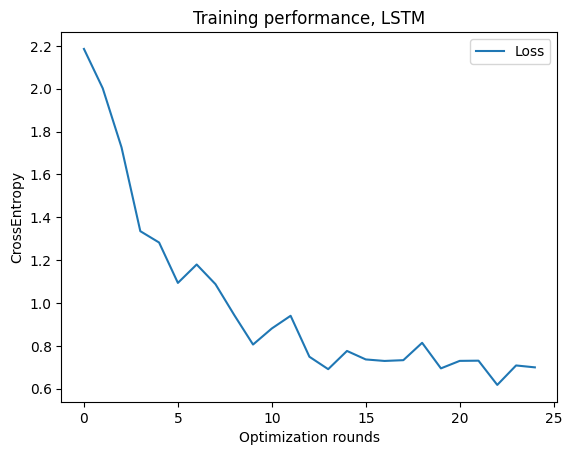

(DefaultActor pid=92318) /opt/homebrew/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(DefaultActor pid=92318)   warnings.warn('resource_tracker: There appear to be %d '


In [51]:
model_variant = 'LSTM' if USE_LSTM else 'RNN'
plot_title = f'Training performance, {model_variant}'
train_losses = [x[1] for x in res.metrics_distributed_fit['losses']]
plt.plot(train_losses, label='Loss')
plt.legend()
plt.xlabel('Optimization rounds')
plt.ylabel('CrossEntropy')
plt.title(plot_title)
plt.grid(False)
plt.savefig(f"./training_loss_{model_variant}.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Performance on test set

In [52]:
model_round = 25
model_name = 'lstm' if USE_LSTM else 'rnn'
net = MultiToOneRNN(hidden_size=hidden_size, LSTM=USE_LSTM)
net.load_state_dict(torch.load(f"classification_model_{model_name}_round_{model_round}.pth"), strict=False)

<All keys matched successfully>

In [53]:
test_data = []
for i, consumer in enumerate(data):
    if i > 40:
        test_data += data[consumer]
test_loader = DataLoader(ClassificationData(test_data), batch_size=batch_size)

In [54]:
def test(net, test_loader):
    """Test the network on the test set."""
    criterion = torch.nn.CrossEntropyLoss()
    num_layers = net.num_layers
    batch_size = test_loader.batch_size
    val_losses = []
    directions = 1 if not net.bidirectional else 2
    net.eval()
    total_loss = 0.0
    golds = []
    preds = []
    for x, Y in tqdm(test_loader):
        Y = Y.to(DEVICE)
        x = x.to(DEVICE).view(x.shape[0], -1, 1)
        hidden = torch.zeros((num_layers*directions, x.shape[0], net.hidden_size)).to(DEVICE)
        cell = torch.zeros((num_layers*directions, x.shape[0], net.hidden_size)).to(DEVICE)
        outs, hidden, cell = net(x, hidden, cell)
        loss = criterion(outs[:, -1], Y)    
        total_loss += loss.item()
        pred = torch.argmax((F.softmax(outs[:, -1], dim=-1)), dim=-1)
        preds += pred.tolist()
        golds += Y.tolist()
    val_losses.append(total_loss / len(test_loader))
    acc = np.mean((np.array(golds) == np.array(preds)))
    print(f' Test loss: {total_loss / len(test_loader)}, accuracy: {acc}')
    return val_losses, preds, golds

In [55]:
losses, preds, golds = test(net, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2059/2059 [01:07<00:00, 30.42it/s]

 Test loss: 1.0730852025799407, accuracy: 0.602034001214329


In [56]:
from collections import Counter

In [57]:
count = Counter(preds)
count

Counter({0: 15968,
         8: 2263,
         9: 2915,
         7: 3416,
         5: 2008,
         6: 2917,
         4: 1652,
         2: 629,
         1: 962,
         3: 210})

In [58]:
matrix = confusion_matrix(golds, preds)

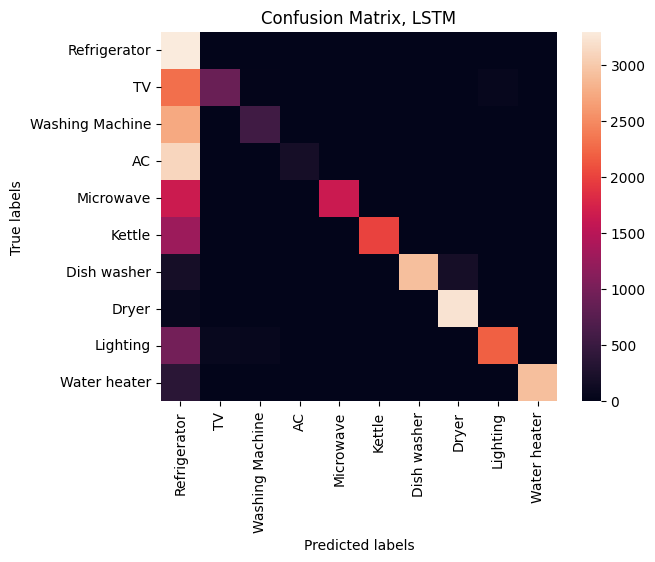

In [59]:
ax= plt.subplot()
sns.heatmap(matrix, annot=False, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title(f'Confusion Matrix, {model_variant}')
ax.xaxis.set_ticklabels(l2idx.keys())
ax.yaxis.set_ticklabels(l2idx.keys())
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig(f"./test_matrix_{model_variant}.pdf", format="pdf", bbox_inches="tight")
plt.show()